In [1]:
import torch
import matplotlib.pyplot as plt

from torch.distributions import Normal, Bernoulli
from utils.losses.elbo_multilevel_reg import elbo, compute_y_hat
from utils.fit import MeanFieldParams, FullRankParams, train_advi
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, roc_auc_score

# Set default type to float64 (instead of float32)
torch.set_default_dtype(torch.float64)

In [2]:
df = pd.read_csv("data/poll88.csv", index_col="Unnamed: 0")
df["femaleblack"] = df["female"]*df["black"]
df["intercept"] = 1.0
df = df[["intercept", "black", "female", "femaleblack", "vprev", "age", "edu", "age_edu", "state", "region", "y"]]

X = df.drop(columns=["y"]).values.astype(float)
y = df["y"].values.astype(float)

In [3]:
X_train = torch.from_numpy(X)[:1815]
y_train = torch.from_numpy(y)[:1815]

X_val = torch.from_numpy(X)[1815:]
y_val = torch.from_numpy(y)[1815:]

In [4]:
y_hat = np.random.randint(0, 2, size=len(y_train))
print(average_precision_score(y_train, y_hat))

0.5533498689050246


In [5]:
target_beta_mean = [-3.5, -1.6, -0.1, -0.2, 7.0]
target_sigma = [0.0, 0.2, 0.2, 0.2, 0.2]

In [6]:
stan_beta = [-3.41297, -1.6683, -0.0898054, -0.199001, 6.90125]
stan_sigma = [0.100038, 0.154194, 0.152685, 0.272737, 0.23287]

In [7]:
advi_mode = "fullrank"
advi_mode = "meanfield"

if advi_mode == "fullrank":
    model_params = {'params': FullRankParams(size=10)}
elif advi_mode == "meanfield":
    model_params = {
        'beta': MeanFieldParams(size=5), 
        'sig': MeanFieldParams(size=5),
    }

elbo_hist_2 = [] 
logpred_hist_2 = []
beta_hist_2 = []
sigma_hist_2 = []

In [8]:
elbo_hist, logpred_hist, beta_hist, sigma_hist = train_advi(
    X_train, y_train, 
    X_val, y_val,
    model_params, elbo, 
    full_data_size=1815, 
    max_iter=10000, 
    batch_size=200, 
    lr=0.1,
    advi_mode=advi_mode,
    elbo_hist=elbo_hist_2,
    logpred_hist=logpred_hist_2,
    beta_hist=beta_hist_2,
    sigma_hist=sigma_hist_2,
)

We plot the elbo history, which seems to indicate convergence.

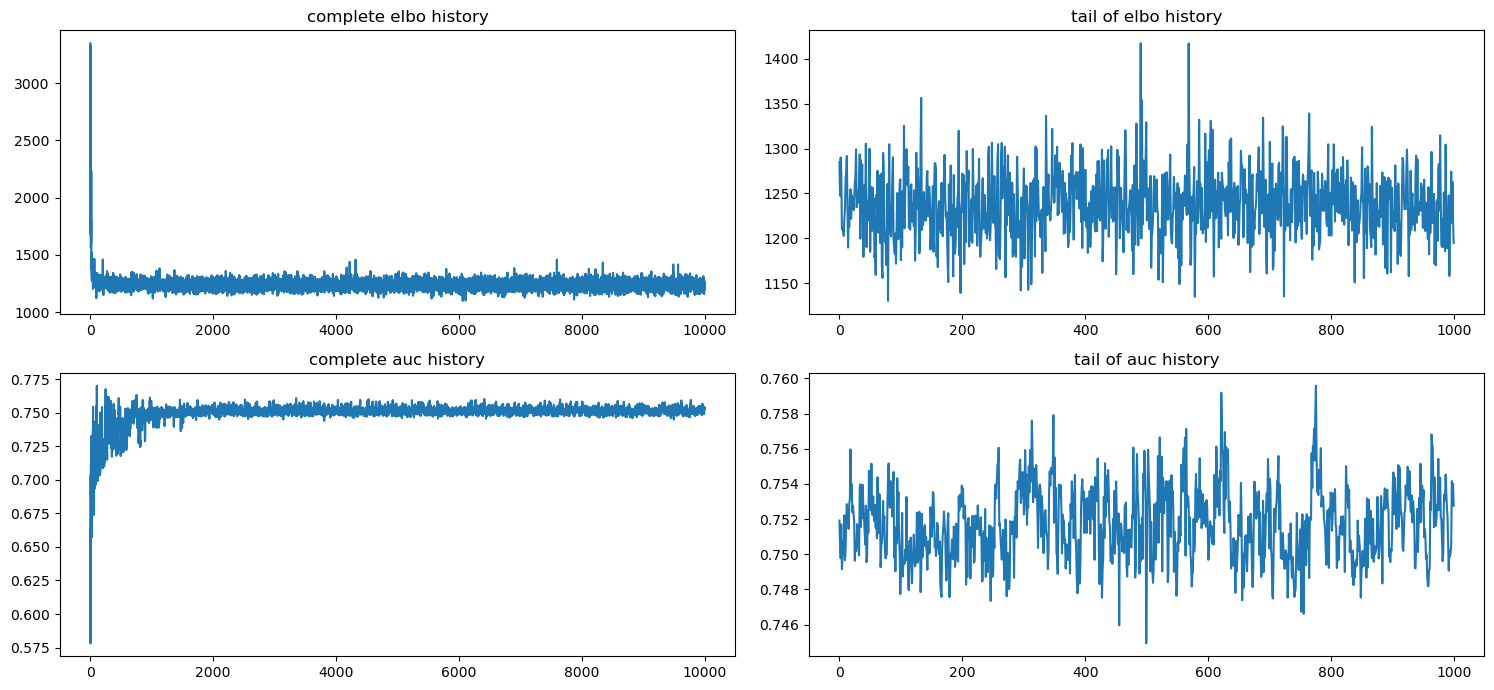

In [9]:
# Plot ELBO history
fig, axes = plt.subplots(2, 2, tight_layout=True, figsize=(15, 7))

axes[0, 0].plot(elbo_hist)
axes[0, 0].set_title('complete elbo history')

# Plot ELBO history (after 100-th iteration)
axes[0, 1].plot(elbo_hist[-1000:])
axes[0, 1].set_title('tail of elbo history')

# Plot ELBO history
axes[1, 0].plot(logpred_hist)
axes[1, 0].set_title('complete auc history')

# Plot ELBO history (after 100-th iteration)
axes[1, 1].plot(logpred_hist[-1000:])
axes[1, 1].set_title('tail of auc history')
plt.show()

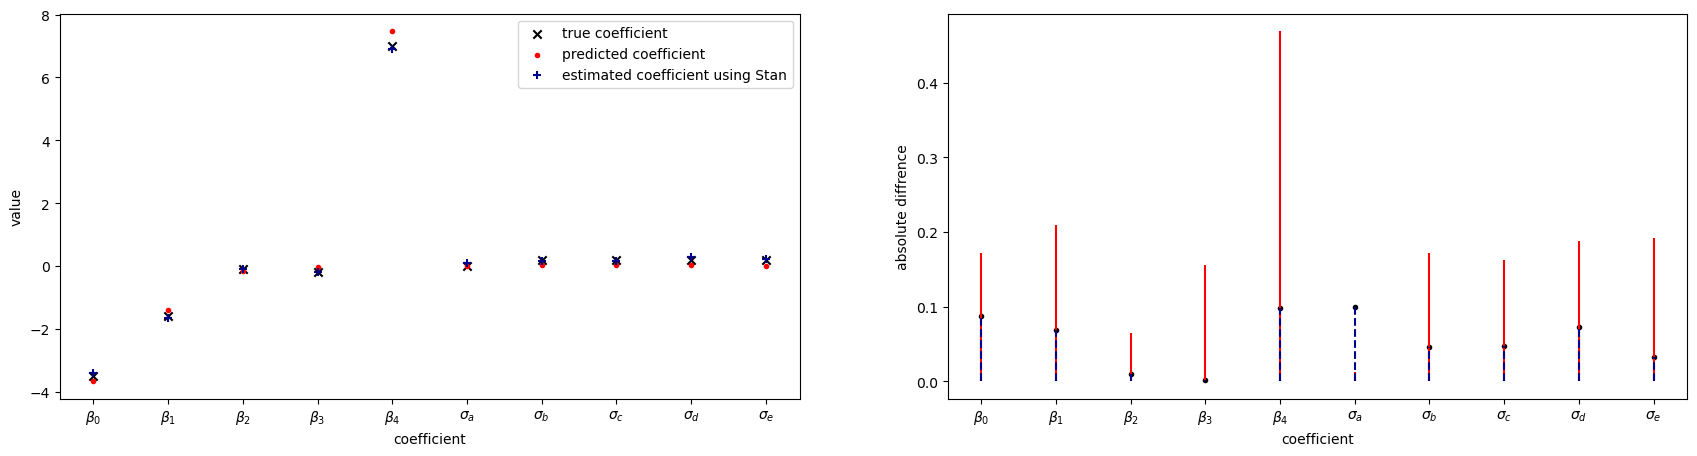

In [10]:
from matplotlib import collections as matcoll

fig, (ax_0, ax_1) = plt.subplots(1, 2, figsize=(21, 5))

ax_0.scatter(x=list(range(10)), y=target_beta_mean+target_sigma, marker="x", c="k", label="true coefficient")
ax_0.scatter(x=list(range(10)), y=list(beta_hist[-1])+list(sigma_hist[-1]), marker=".", c="r", label="predicted coefficient")
ax_0.scatter(x=list(range(10)), y=stan_beta+stan_sigma, marker="+", c="darkblue", label="estimated coefficient using Stan")
ax_0.set_xlabel("coefficient")
ax_0.set_ylabel("value")
ax_0.set_xticks(list(range(10)))
ax_0.set_xticklabels([f"$\\beta_{i}$" for i in range(5)]+[f"$\\sigma_{c}$" for c in ["a", "b", "c", "d", "e"]])
ax_0.legend()

y = np.abs(np.array(target_beta_mean+target_sigma) - np.array(list(beta_hist[-1])+list(sigma_hist[-1])))
lines = []
for i in range(10):
    pair=[(i, 0), (i, y[i])]
    lines.append(pair)
linecoll = matcoll.LineCollection(lines, colors="r", linestyle="-")
ax_1.add_collection(linecoll)

y = np.abs(np.array(target_beta_mean+target_sigma) - np.array(stan_beta+stan_sigma))
lines = []
for i in range(10):
    pair=[(i, 0), (i, y[i])]
    lines.append(pair)
linecoll = matcoll.LineCollection(lines, colors="darkblue", linestyle="--")
ax_1.add_collection(linecoll)

ax_1.scatter(x=list(range(10)), y=y, marker=".", c="k")
ax_1.set_xlabel("coefficient")
ax_1.set_xticks(list(range(10)))
ax_1.set_xticklabels([f"$\\beta_{i}$" for i in range(5)]+[f"$\\sigma_{c}$" for c in ["a", "b", "c", "d", "e"]])
ax_1.set_ylabel("absolute diffrence")


plt.show()
plt.close()

In [11]:
def transform(array):
    a = array[:5]
    b = array[5:]
    return np.concatenate([a, np.exp(b)])

In [12]:
print('True beta: {}'.format(target_beta_mean))
print('True sigma: {}'.format(target_sigma))
print()

if advi_mode == "fullrank":
    beta_mean = transform(model_params['params'].mean.detach().numpy())
    print('param mean: {}'.format(beta_mean))
    beta_std = model_params['params'].L.detach().numpy()
    beta_std = np.array_str(beta_std@beta_std.T, precision=4, suppress_small=True)
    print('param sd: \n{}'.format(beta_std))

elif advi_mode == "meanfield":
    beta_mean = model_params['beta'].mean.detach().numpy()
    print('beta mean: {}'.format(beta_mean))
    beta_std = model_params['beta'].log_s.exp().detach().numpy()
    beta_std = np.array_str(beta_std, precision=4, suppress_small=True)
    print('beta sd: {}'.format(beta_std))
    sig_mean = model_params['sig'].mean.exp().detach().numpy()
    print('sig mean: {}'.format(sig_mean))
    sig_std = model_params['sig'].log_s.exp().detach().numpy()
    print('sig std: {}'.format(sig_std))

True beta: [-3.5, -1.6, -0.1, -0.2, 7.0]
True sigma: [0.0, 0.2, 0.2, 0.2, 0.2]

beta mean: [-3.79447743 -1.8258178  -0.04430808 -0.46313437  7.38413166]
beta sd: [0.0385 0.2484 0.0437 0.1898 0.0605]
sig mean: [0.04121583 0.03169847 0.01881035 0.02916347 0.03328824]
sig std: [0.19850121 0.81745936 0.67210309 0.56709967 0.44966353]
